In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

In [2]:
# import libraries
import numpy as np
import cv2
import glob
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from src.utility_funcs import *
from src.lane_line_validation import *
from src.Line import Line

%matplotlib inline

In [3]:
# parameters for camera calibration
corner_x = 9 # how many corners in x direction of the chess board
corner_y = 6 # how many corners in y direction of the chess board

# define some normal variables
ksize = 15 # kernel size for image gradient thresholds

x = 1280 # image width
y = 720 # image height

# sliding windows constants
width = 120 
height = 120
stride = 10
search_range = 300

# perspective transformation
offset_top = 590 # top left & right offset in original image 
offset_btm = 200 # bottom left & right offset in original image 
offset_dst = 300 # offset in bird view image

# meters per pixel (Convert from picture to real world distance)
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# detected lane checking params
curvature_diff_tolerance = 2000 # difference tolerance between current image with average of near previous ones.
distance_tolerance = 1000 # how many pixels are allowed between left lane bottom and right lane bottom in current image. 
continue_miss_threshold = 30 # how many continuous undetermined images are allowed before trash previous imgs  

# get perspective transform M and inverse perspective transform Minv
src = np.float32([(offset_top, 450), (x-offset_top, 450), (x-offset_btm, y), (offset_btm, y)])
dst = np.float32([(offset_dst, 0), (x-offset_dst, 0), (x-offset_dst, y), (offset_dst, y)])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [4]:
# get camera calibration parameters mtx and dist
mtx, dist = get_camera_mtx_dist('media/camera_cal/calibra*.jpg', corner_x, corner_y, x, y)

In [5]:
def detect_lane_line_pipeline(img):
    global left_lane
    global right_lane,z
    global continue_miss_threshold
    
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    
    threshold_img = get_threshold_img(undistort, ksize)
    
    warped = cv2.warpPerspective(threshold_img, M, (x,y))
    
    # left_lane_patches is (window_start_x, window_low_y)
    left_lane_patches, right_lane_patches = get_sliding_window(warped, y, height, width, search_range, stride)
    
    # return a list of rectangles, 4 points of the it.  
    left_roi_x, left_roi_y = get_sliding_window_combined(left_lane_patches, width, height)
    left_real_world_curvature = get_real_world_curvature(left_roi_x, left_roi_y, y, ym_per_pix, xm_per_pix, side='left')
    left_fitx, left_roi_y, left_coeff = get_polyfit(left_roi_y, left_roi_x)
    

    right_roi_x, right_roi_y = get_sliding_window_combined(right_lane_patches, width, height)
    right_real_world_curvature = get_real_world_curvature(right_roi_x, right_roi_y, y, ym_per_pix, xm_per_pix, side='right')
    right_fitx, right_roi_y, right_coeff = get_polyfit(right_roi_y, right_roi_x)
    
    # check whether the detected lines are real line or not, use previous real lane line data.
    tf_real_lanes = are_lanes_detected(left_lane, left_real_world_curvature, left_fitx, \
                                       right_lane, right_real_world_curvature, right_fitx, curvature_diff_tolerance,
                                       distance_tolerance)

    # if lane lines are correctly detected, update them. If not, use the old ones
    if left_lane.continuous_missed_frames > continue_miss_threshold:
        left_lane.reset('left')
        right_lane.reset('right')
    elif tf_real_lanes:
        offset_from_lane_center = cal_offset_from_lane_center(left_fitx[-1], right_fitx[-1], x, xm_per_pix)
        # update parameters in lanes
        left_lane.update_params(left_fitx, left_roi_y, tf_real_lanes, left_real_world_curvature, offset_from_lane_center, left_coeff)
        right_lane.update_params(right_fitx, right_roi_y, tf_real_lanes, right_real_world_curvature, offset_from_lane_center, right_coeff)
    else:
        left_lane.continuous_missed_frames += 1
    # average between the last n and draw them
    if left_lane.bestx is None or right_lane.bestx is None:
        result = undistort
    else:  
        #color_warp = get_roi_poly_bird_view(undistort, warped, left_fitx, left_roi_y, right_fitx, right_roi_y)
        color_warp = get_roi_poly_bird_view(undistort, warped, left_lane.bestx, left_roi_y, \
                                            right_lane.bestx, right_roi_y)
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        result = cv2.addWeighted(undistort, 1, newwarp, 0.3, 0)

    return result

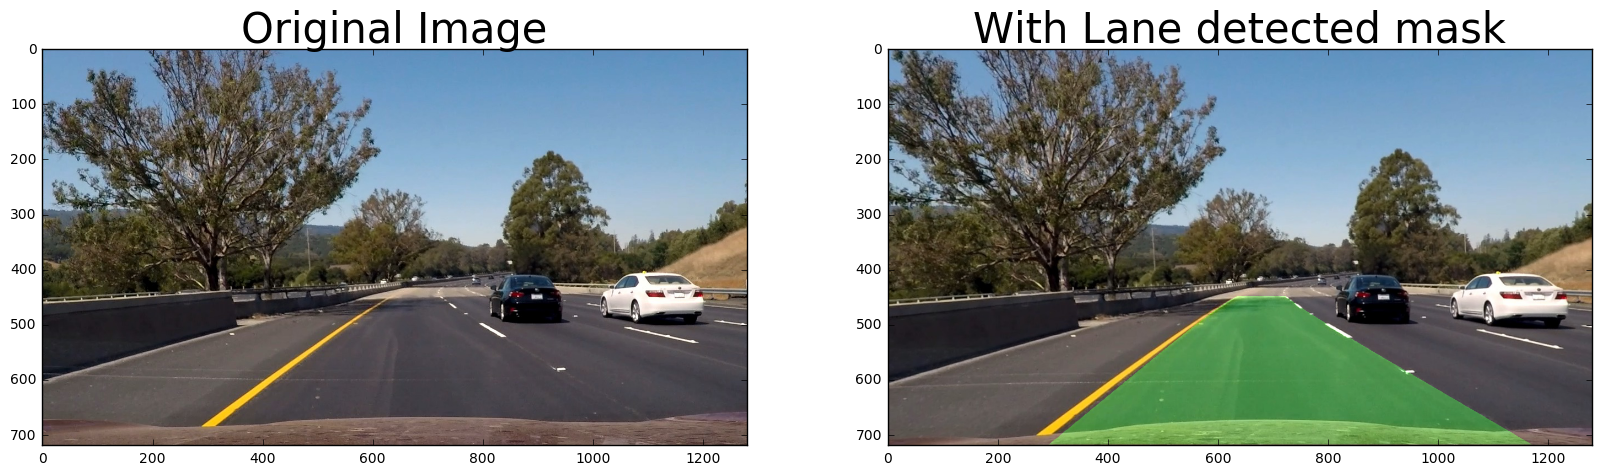

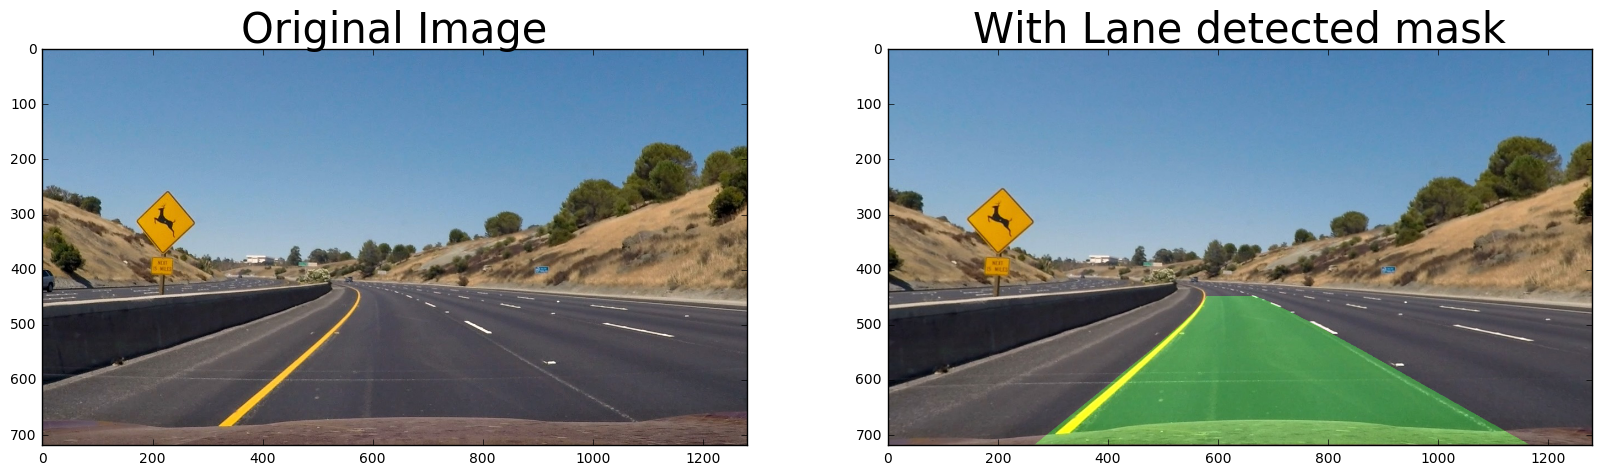

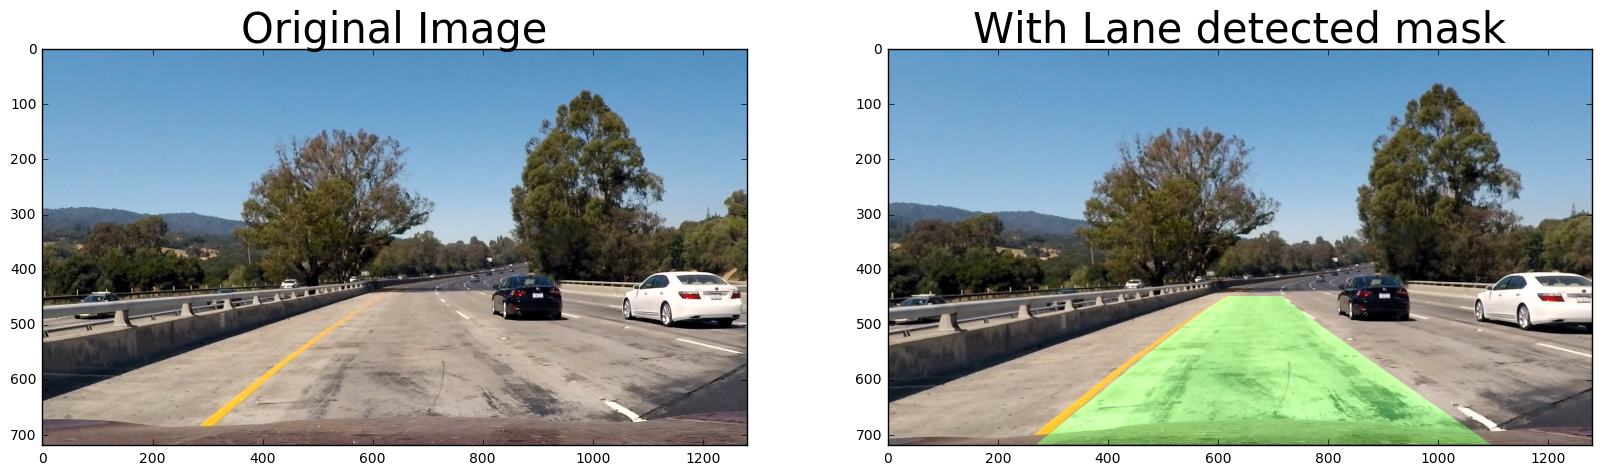

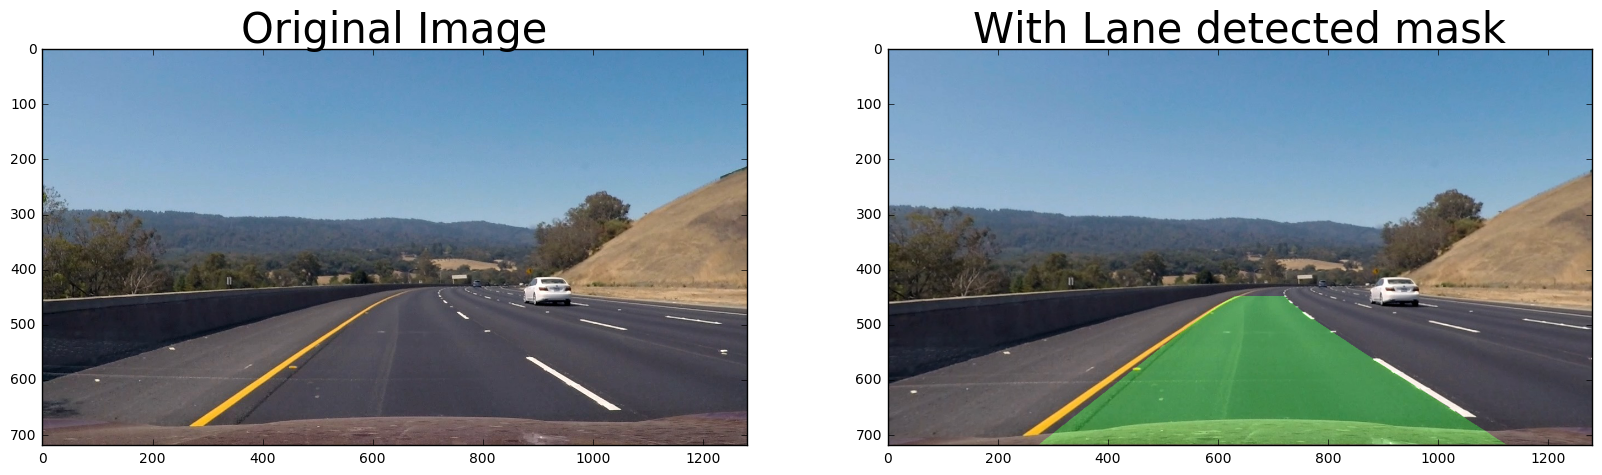

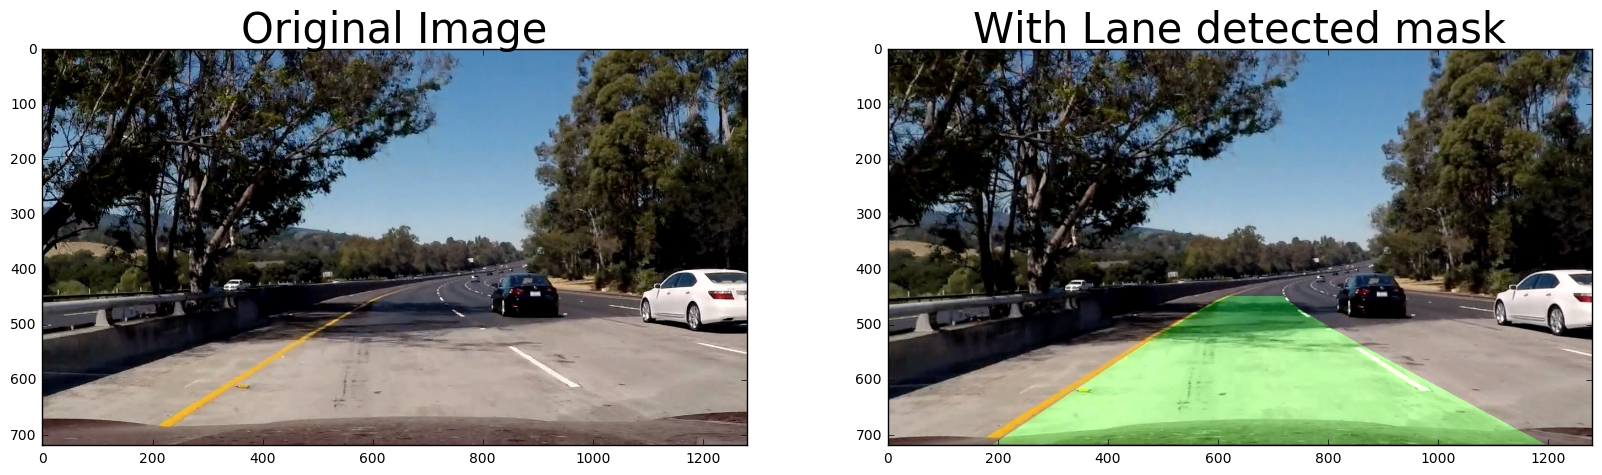

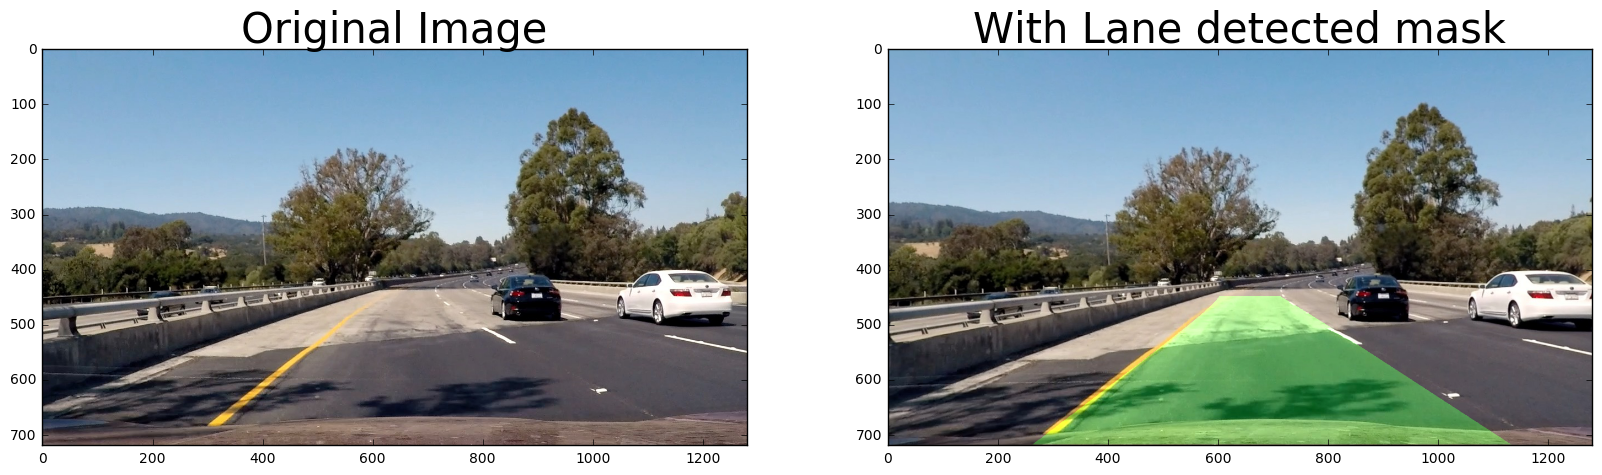

In [6]:
test_images = glob.glob('media/test_images/test*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(test_images):
    left_lane = Line('left')
    right_lane = Line('right')
    img = cv2.imread(fname)
    result = detect_lane_line_pipeline(img)
    plot_orig_and_processed_img(img, result, 'Original Image', 'With Lane detected mask')
    

In [7]:
# test on videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
left_lane = Line('left')
right_lane = Line('right')
white_output = './media/videos/proj_video_processed.mp4'
clip1 = VideoFileClip("./media/videos/project_video.mp4")
white_clip = clip1.fl_image(detect_lane_line_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./media/videos/proj_video_processed.mp4
[MoviePy] Writing video ./media/videos/proj_video_processed.mp4


100%|█████████▉| 1260/1261 [20:28<00:00,  1.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./media/videos/proj_video_processed.mp4 

CPU times: user 1h 7min 8s, sys: 5min 13s, total: 1h 12min 21s
Wall time: 20min 30s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))